## Import necessary packages

In [1]:
# General
import os
import numpy as np

# Azure blob storage related
from azure.storage.blob import BlobServiceClient, __version__
try:
    print(f'Azure blob storage v{__version__}')
except Exception as ex:
    print(ex)

Azure blob storage v12.6.0


## Investigate the stored data

We only have the connection string at hand, it doesn't specify any information about the containers, so firstly we need to look into it:

### List containers of the account

In [11]:
connection_string = 'DefaultEndpointsProtocol=https;AccountName=tmptask;AccountKey=bsNjOiTW35QqxGVm4qlBbQ+6E3zGA/IK1qV4VzOYUDJ3R3xqEyCFIvCTK0VvLR0nBNiv5kkPOKHkioqBVgk14g==;EndpointSuffix=core.chinacloudapi.cn'

In [3]:
service = BlobServiceClient.from_connection_string(conn_str=connection_string)

In [4]:
for container in service.list_containers():
    print(container.name)

ronglz
vibopt


So we have two available. Next step: get some sample data from each to see which one (or maybe both) matches the task description.

### Investigate the `ronglz` container

In [5]:
container_1 = service.get_container_client('ronglz')

In [6]:
len(list(container_1.list_blobs()))

114

#### Define some helper

In [3]:
def list_blob_names(container, count=10):
    for blob in container.list_blobs():
        if not count:
            break
        else:
            print(blob.name)
            count -= 1

#### List the first 3 blob names

In [8]:
list_blob_names(container_1, 3)

00000000_log.gz
00000001_log.gz
00000002_log.gz


Looks like the one we targeted:)

### Investigate the `vibopt` container

In [9]:
container_2 = service.get_container_client('vibopt')

In [10]:
len(list(container_2.list_blobs()))

7856

#### List the first 3 blob names

In [11]:
list_blob_names(container_2, 3)

AnotherConfSample.json
ConfSample.json
VibParameterSample.json


Emmm, this one seems to be off-topic.

### Summary of the investigation

We found 2 containers in the given Azure blob storage account, and only one of them (`ronglz`) looked like the correct one to proceed with, since it contains the log-like data. We'll go with the `ronglz` container in the following sections.

In [9]:
container = container_1

## Play with a single blob

Let's try to do the statistics on the data within a single blob first. We'll download the first blob file `00000000_log.gz` to get started.

In [12]:
data_dir = 'task_data'
os.makedirs(data_dir, exist_ok=True)

In [13]:
count = 1
for blob in container.list_blobs():
    if not count:
        break
    else:
        with open(os.path.join(data_dir, blob.name), 'wb') as f:
            download_stream = container.download_blob(blob.name)
            f.write(download_stream.readall())
        count = count - 1

### Process the data

First try to parse the single line:

In [4]:
import gzip

In [13]:
lines = []
count = 100
with gzip.open(os.path.join(data_dir, '00000000_log.gz'), 'rt') as f:
    while count:
        lines.append(f.readline())
        count -= 1

Look at several lines to get feelings:

In [14]:
lines[0]

'DEBUG 20200812 092459.775200 177626 | #2135000001 MD|I=000007.SZ,ETS=09:25:00.000,L=8.96,V=13800,B1=8.88:10100,A1=8.96:10800,B2=8.85:1600,A2=9:21700,B3=8.81:5300,A3=9.02:800,B4=8.78:2800,A4=9.03:5000,B5=8.71:2000,A5=9.05:1200,T=123648.000000 - app_aid_report.c:252\n'

In [15]:
lines[1]

'DEBUG 20200812 092459.775225 177626 | ##2135000001 000007.SZ prediction=0, raw=0, theo0=0, bp=0,sp=0,q_bp=0,q_sp=0,bv1=0,bv2=0,av1=0,av2=0 - app_aid_report.c:267\n'

#### Define the line parser and the stats updater

In [5]:
from datetime import datetime

In [6]:
def get_seconds(time_str):
    return (datetime.strptime(time_str, '%H:%M:%S.%f') - datetime(1900, 1, 1)).total_seconds()

In [7]:
def parse_line(line):
    tokens = line.split(',')
    header = tokens[0]
    parts = [token.strip() for token in header.split('|')]
    if len(parts) == 2:  # prediction
        _idx, stock_id, _prediction = parts[1].split()
        idx = _idx[2:]
        prediction = float(_prediction.split('=')[1])
        return stock_id, idx, prediction
    elif len(parts) == 3:  # market log
        _idx = parts[1].split()[0]
        idx = _idx[1:]
        stock_id = parts[2].split('=')[1]
        time_str = tokens[1].split('=')[1]
        t = get_seconds(time_str)
        # Calculate mid-value y
        B1_tokens = tokens[4].split('=')
        if B1_tokens[0] == 'B1':
            B1 = float(B1_tokens[1].split(':')[0])
        else:
            raise Exception('Malformed data: B1')
        A1_tokens = tokens[5].split('=')
        if A1_tokens[0] == 'A1':
            A1 = float(A1_tokens[1].split(':')[0])
        else:
            raise Exception('Malformed data: A1')
        y = (A1 + B1) / 2
        if A1 <= B1:
            # invalid value, but keeping it to make sure
            # that the idx in cache doesn't jump
            y = np.nan
        return stock_id, idx, y, t
    else:
        raise Exception('Malformed data: header')

In [8]:
def is_invalid(record):
    return (record['t'] is np.nan) or (record['f'] is np.nan) or (record['mt'] is np.nan) or (record['mtn'] is np.nan)

In [9]:
def update_stats(stocks_stats, line, n=5, tol=1):
    try:
        params = parse_line(line)
    except Exception as e:
        print('error!')
        return stocks_stats
    
    # Create the stats record for the stock if it doesn't exist yet
    stock_id = params[0]
    try:
        stats = stocks_stats[stock_id]
    except KeyError:
        stocks_stats[stock_id] = {
            'count': 0,  # number of the full-info points
            'y_m': 0,  # mean of the real values
            'y_ms': 0,  # mean square of the real values
            'res_ms': 0,  # mean square of the residuals
            'cache': [],  # cached market/prediction data of the last n seconds
            'invalid': [],  # optional, store the invalid points that removed from cache
            'idx_f': -1,  # index of the latest prediction line in the cache
            'idx_y': -1  # index of the latest market line in the cache 
        }
        stats = stocks_stats[stock_id]
    
    # Fill the new data into the cache
    if len(params) == 4:  # market log
        stock_id, idx, mt, t = params
        idx_y_prev = stats['idx_y']
        while True:
            idx_y = stats['idx_y'] + 1  # the new y index
            stats['idx_y'] = idx_y  # update the y index in record
            if idx_y < len(stats['cache']):
                if idx == stats['cache'][idx_y]['idx']:
                    stats['cache'][idx_y]['t'] = t
                    stats['cache'][idx_y]['mt'] = mt
                    break
                elif idx > stats['cache'][idx_y]['idx']:
                    # data jump occurred
                    # which means this record will never be fullfilled
                    stats['cache'][idx_y]['t'] = np.nan
                    stats['cache'][idx_y]['mt'] = np.nan
                else:
                    raise Exception('Malformed data: order')
            else:
                stats['cache'].append({
                    'idx': idx,
                    't': t,
                    'f': None,
                    'mt': mt,
                    'mtn': None
                })
                break
                
        # Try to fulfill the old cached data
        i = 0
        cache_size = len(stats['cache'])
        while i < cache_size:
            if stats['cache'][i]['mtn'] is not None:
                i += 1
                continue
            
            dt = t - stats['cache'][i]['t']
            if dt >= n:
                # Look back to find the closest record
                if idx_y_prev != -1:
                    t_prev = stats['cache'][idx_y_prev]['t']
                    dt_prev = t_prev - stats['cache'][i]['t']
                    # If the previous point is closer, use the previous one
                    if n - dt_prev < dt - n:
                        if n - dt_prev <= tol:
                            stats['cache'][i]['mtn'] = stats['cache'][idx_y_prev]['mt']
                        else:
                            stats['cache'][i]['mtn'] = np.nan
                        continue
                
                if dt <= n + tol:
                    stats['cache'][i]['mtn'] = mt
                else:
                    stats['cache'][i]['mtn'] = np.nan
                i += 1
            else:
                break
                
    elif len(params) == 3:  # prediction
        stock_id, idx, f = params
        while True:
            idx_f = stats['idx_f'] + 1  # the new f index
            stats['idx_f'] = idx_f  # update the f index in record
            if idx_f < len(stats['cache']):
                if idx == stats['cache'][idx_f]['idx']:
                    stats['cache'][idx_f]['f'] = f
                    break
                elif idx > stats['cache'][idx_f]['idx']:
                    # data jump occurred
                    # which means this record will never be fulfilled
                    stats['cache'][idx_f]['f'] = np.nan
                else:
                    raise Exception('Malformed data: order')
            else:
                stats['cache'].append({
                    'idx': idx,
                    't': None,
                    'f': f,
                    'mt': None,
                    'mtn': None
                })
                break
    else:
        print('not gonna happen:)')
        return stocks_stats
        
    # See if the old cached data can be processed and/or removed
    while len(stats['cache']):
        if is_invalid(stats['cache'][0]):
            invalid_record = stats['cache'].pop(0)
            stats['invalid'].append(invalid_record)
            if stats['idx_y'] != -1:
                stats['idx_y'] -= 1
            if stats['idx_f'] != -1:
                stats['idx_f'] -= 1
        else:
            try:
                f = stats['cache'][0]['f']
                mt = stats['cache'][0]['mt']
                mtn = stats['cache'][0]['mtn']
                y = (mtn - mt) / mt * 1000
                res = y - f  # this one will throw a TypeError if not fulfilled
                # If successfully pass the line above, we can safely process the record
                count = stats['count']
                y_m = stats['y_m']
                y_ms = stats['y_ms']
                res_ms = stats['res_ms']
                stats['y_m'] = count / (count + 1) * y_m + 1 / (count + 1) * y
                stats['y_ms'] = count / (count + 1) * y_ms + 1 / (count + 1) * y ** 2
                stats['res_ms'] = count / (count + 1) * res_ms + 1 / (count + 1) * res ** 2
                stats['count'] = count + 1
                # Remove the record from cache
                stats['cache'].pop(0)
                if stats['idx_y'] != -1:
                    stats['idx_y'] -= 1
                if stats['idx_f'] != -1:
                    stats['idx_f'] -= 1
            except TypeError:
                break
        
    return stocks_stats

#### Fill-in the stocks stats

In [21]:
stocks_stats = {}

In [22]:
with gzip.open(os.path.join(data_dir, '00000000_log.gz'), 'rt') as f:
    for line in f:
        try:
            stocks_stats = update_stats(stocks_stats, line)
        except Exception as e:
            print(idx, line)
            raise(e)

#### Check if the cache looks reasonable

Use the stock `000609.SZ` as a sample:

In [23]:
stats = stocks_stats['000609.SZ']
stats

{'count': 44,
 'y_m': -0.017977835,
 'y_ms': 2.4423295,
 'res_ms': 2.7619668,
 'cache': [{'idx': '2135270369',
   't': 34231.11,
   'f': 0.94336534,
   'mt': 6.01,
   'mtn': None},
  {'idx': '2135271076',
   't': 34231.2,
   'f': 0.20439202,
   'mt': 6.015,
   'mtn': None},
  {'idx': '2135279346',
   't': 34232.81,
   'f': 0.20439202,
   'mt': 6.015,
   'mtn': None},
  {'idx': '2135280348',
   't': 34233.05,
   'f': 0.20439202,
   'mt': 6.015,
   'mtn': None},
  {'idx': '2135287219',
   't': 34234.17,
   'f': 0.20439202,
   'mt': 6.015,
   'mtn': None},
  {'idx': '2135294416',
   't': 34235.45,
   'f': 1.3869853,
   'mt': 6.015,
   'mtn': None},
  {'idx': '2135294417',
   't': 34235.45,
   'f': 1.3869853,
   'mt': 6.015,
   'mtn': None},
  {'idx': '2135294478',
   't': 34235.46,
   'f': 1.3869853,
   'mt': 6.015,
   'mtn': None}],
 'invalid': [{'idx': '2135000120',
   't': 33900,
   'f': 0,
   'mt': 6.005,
   'mtn': nan},
  {'idx': '2135042952', 't': nan, 'f': -0.069153666, 'mt': nan, 

#### Calculate the current R squared

Let's calculate the current R sqaured for `000609.SZ`:

In [24]:
R_squared = 1 - stats['res_ms'] / (stats['y_ms'] - stats['y_m'] ** 2)
R_squared

-0.13102365

Looks like the prediction was pretty bad lol

#### Visualize the cached records

Let's look closer by doing some plotting of the cached records:

In [25]:
data = np.array([[record['t'], record['mt'], record['f']] for record in stats['cache']])

In [26]:
data

array([[3.4231110e+04, 6.0100000e+00, 9.4336534e-01],
       [3.4231200e+04, 6.0150000e+00, 2.0439202e-01],
       [3.4232810e+04, 6.0150000e+00, 2.0439202e-01],
       [3.4233050e+04, 6.0150000e+00, 2.0439202e-01],
       [3.4234170e+04, 6.0150000e+00, 2.0439202e-01],
       [3.4235450e+04, 6.0150000e+00, 1.3869853e+00],
       [3.4235450e+04, 6.0150000e+00, 1.3869853e+00],
       [3.4235460e+04, 6.0150000e+00, 1.3869853e+00]])

In [27]:
import matplotlib.pyplot as plt

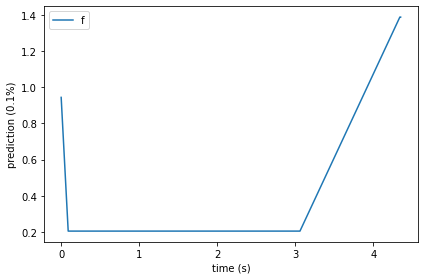

In [28]:
fig, ax = plt.subplots(1, 1)
ax.set(xlabel='time (s)', ylabel='prediction (0.1%)')

# ax.plot(data[:, 0] - data[0, 0], data[:, 1], '-', label='mt')
ax.plot(data[:, 0] - data[0, 0], data[:, 2], '-', label='f')

ax.legend(loc=0)
fig.tight_layout()

plt.show()

Note that the x range is around 5 seconds, which agrees with our cache idea, that we only need to cache the data within the latest 5s to calculate everything we need. In this way, we can use the minimal memory to complete our task. It might be overkilled though.

#### The invalid data along the statistics

Now let's check the invalid data accumulated along the way:

In [29]:
stats['invalid']

[{'idx': '2135000120', 't': 33900, 'f': 0, 'mt': 6.005, 'mtn': nan},
 {'idx': '2135042952', 't': nan, 'f': -0.069153666, 'mt': nan, 'mtn': None}]

The first invalid record means that there was no market record that was `n` seconds ahead of the record `2135000120`, where `n` between 4 and 6. So there's no way to calculate a reliable `mtn`.

The second invalid record comes from the data jumping, which means that there was no market record for the specific data index `2135042952`, while there was a prediction for that index.

The above 2 types of faults are the main source of all the fault records.

## Do statistics on all the blobs

In [12]:
import pickle
from tqdm.auto import tqdm

In [13]:
def load_checkpoint(ckpt_dir):
    time_str_list = [os.path.splitext(p)[0] for p in os.listdir(ckpt_dir) if os.path.splitext(p)[1] == '.ckpt']
    try:
        time_str_latest = sorted(time_str_list, key=lambda ts: datetime.strptime(ts, '%y%m%d_%H%M%S'), reverse=True)[0]
    except IndexError:
        data_init = {
            'idx': -1,
            'blob': None,
            'stocks_stats': {}
        }
        return data_init
    
    with open(os.path.join(ckpt_dir, f'{time_str_latest}.ckpt'), 'rb') as f:
        data = pickle.load(f)
    return data

In [14]:
def save_checkpoint(ckpt_dir, data):
    time_str = datetime.now().strftime('%y%m%d_%H%M%S')
    with open(os.path.join(ckpt_dir, f'{time_str}.ckpt'), 'wb') as f:
        pickle.dump(data, f)

In [15]:
def do_statistics(conn_str, ctr_name='ronglz', data_dir='task_data', ckpt_dir='task_checkpoints'):
    # Makedirs
    data_dir = 'task_data'
    os.makedirs(data_dir, exist_ok=True)
    ckpt_dir = 'task_checkpoints'
    os.makedirs(ckpt_dir, exist_ok=True)
    
    # Load the latest checkpoint
    data = load_checkpoint(ckpt_dir)
    idx = data['idx']
    blob_name = data['blob']
    stocks_stats = data['stocks_stats']
    
    # Connect to the container
    service = BlobServiceClient.from_connection_string(conn_str=conn_str)
    container = service.get_container_client(ctr_name)
    
    blobs = list(container.list_blobs())  # do this to give tqdm a total count
    if idx != -1:
        assert blob_name == blobs[idx].name, 'blobs might have been changed!'
        
    for i, blob in enumerate(tqdm(blobs[idx + 1:])):
        # Download the blob
        with open(os.path.join(data_dir, blob.name), 'wb') as f:
            download_stream = container.download_blob(blob.name)
            f.write(download_stream.readall())

        # Update the stocks stats
        with gzip.open(os.path.join(data_dir, blob.name), 'rt') as f:
            for line in f:
                try:
                    stocks_stats = update_stats(stocks_stats, line)
                except Exception as e:
                    print(idx, line)
                    raise(e)

        # Save the checkpoint
        checkpoint = {
            'idx': idx + 1 + i,
            'blob': blob.name,
            'stocks_stats': stocks_stats
        }
        save_checkpoint(ckpt_dir, checkpoint)

### Let's do it

In [18]:
do_statistics(connection_string)

OSError: [Errno 28] No space left on device

---

## Backlogs

In [66]:
time_str_list = [os.path.splitext(p)[0] for p in os.listdir(ckpt_dir) if os.path.splitext(p)[1] == '.ckpt']

In [71]:
time_str_list.append('201128_233031')

In [72]:
sorted(time_str_list, key=lambda ts: datetime.strptime(ts, '%y%m%d_%H%M%S'), reverse=True)

['201128_235303', '201128_233031', '201128_231104']

In [ ]:
sorted([], key=lambda ts: datetime.strptime(ts, '%y%m%d_%H%M%S'), reverse=True)[0]

In [64]:
datetime.strptime(time_str, '%y%m%d_%H%M%S') > datetime.strptime('201128_235103', '%y%m%d_%H%M%S')

True

In [60]:
time_str

'201128_235303'

In [54]:
os.path.splitext('123.ckpt')

('123', '.ckpt')

In [31]:
# Save the checkpoint
checkpoint = {
    'blob': '0001',
    'stocks_stats': stocks_stats
}

with open(os.path.join(ckpt_dir, '0001.ckpt'), 'wb') as f:
    pickle.dump(checkpoint, f)

In [32]:
with open(os.path.join(ckpt_dir, '0001.ckpt'), 'rb') as f:
    ckpt = pickle.load(f)

In [44]:
blobs = list(container.list_blobs())

---

In [72]:
def update_stats_s(stocks_stats, line, n=5, tol=1):
    try:
        params = parse_line(line)
    except Exception as e:
        print('error!')
        return stocks_stats
    
    # Create the stats record for the stock if it doesn't exist yet
    stock_id = params[0]
    try:
        stats = stocks_stats[stock_id]
    except KeyError:
        stocks_stats[stock_id] = {
            'count': 0,  # number of the full-info points
            'y_s': 0,  # sum of the real values
            'y_ss': 0,  # square sum of the real values
            'res_ss': 0,  # square sum of the residuals
            'cache': [],  # cached market/prediction data of the last n seconds
            'invalid': [],  # optional, store the invalid points that removed from cache
            'idx_f': -1,  # index of the latest prediction line in the cache
            'idx_y': -1  # index of the latest market line in the cache 
        }
        stats = stocks_stats[stock_id]
    
    # Fill the new data into the cache
    if len(params) == 4:  # market log
        stock_id, idx, mt, t = params
        idx_y_prev = stats['idx_y']
        while True:
            idx_y = stats['idx_y'] + 1  # the new y index
            stats['idx_y'] = idx_y  # update the y index in record
            if idx_y < len(stats['cache']):
                if idx == stats['cache'][idx_y]['idx']:
                    stats['cache'][idx_y]['t'] = t
                    stats['cache'][idx_y]['mt'] = mt
                    break
                elif idx > stats['cache'][idx_y]['idx']:
                    # data jump occurred
                    # which means this record will never be fullfilled
                    stats['cache'][idx_y]['t'] = np.nan
                    stats['cache'][idx_y]['mt'] = np.nan
                else:
                    raise Exception('Malformed data: order')
            else:
                stats['cache'].append({
                    'idx': idx,
                    't': t,
                    'f': None,
                    'mt': mt,
                    'mtn': None
                })
                break
                
        # Try to fulfill the old cached data
        i = 0
        cache_size = len(stats['cache'])
        while i < cache_size:
            if stats['cache'][i]['mtn'] is not None:
                i += 1
                continue
            
            dt = t - stats['cache'][i]['t']
            if dt >= n:
                # Look back to find the closest record
                if idx_y_prev != -1:
                    t_prev = stats['cache'][idx_y_prev]['t']
                    dt_prev = t_prev - stats['cache'][i]['t']
                    # If the previous point is closer, use the previous one
                    if n - dt_prev < dt - n:
                        if n - dt_prev <= tol:
                            stats['cache'][i]['mtn'] = stats['cache'][idx_y_prev]['mt']
                        else:
                            stats['cache'][i]['mtn'] = np.nan
                        continue
                
                if dt <= n + tol:
                    stats['cache'][i]['mtn'] = mt
                else:
                    stats['cache'][i]['mtn'] = np.nan
                i += 1
            else:
                break
                
    elif len(params) == 3:  # prediction
        stock_id, idx, f = params
        while True:
            idx_f = stats['idx_f'] + 1  # the new f index
            stats['idx_f'] = idx_f  # update the f index in record
            if idx_f < len(stats['cache']):
                if idx == stats['cache'][idx_f]['idx']:
                    stats['cache'][idx_f]['f'] = f
                    break
                elif idx > stats['cache'][idx_f]['idx']:
                    # data jump occurred
                    # which means this record will never be fulfilled
                    stats['cache'][idx_f]['f'] = np.nan
                else:
                    raise Exception('Malformed data: order')
            else:
                stats['cache'].append({
                    'idx': idx,
                    't': None,
                    'f': f,
                    'mt': None,
                    'mtn': None
                })
                break
    else:
        print('not gonna happen:)')
        return stocks_stats
        
    # See if the old cached data can be processed and/or removed
    while len(stats['cache']):
        if is_invalid(stats['cache'][0]):
            invalid_record = stats['cache'].pop(0)
            stats['invalid'].append(invalid_record)
            if stats['idx_y'] != -1:
                stats['idx_y'] -= 1
            if stats['idx_f'] != -1:
                stats['idx_f'] -= 1
        else:
            try:
                f = stats['cache'][0]['f']
                mt = stats['cache'][0]['mt']
                mtn = stats['cache'][0]['mtn']
                y = (mtn - mt) / mt * 1000
                res = y - f  # this one will throw a TypeError if not fulfilled
                # If successfully pass the line above, we can safely process the record
                stats['y_s'] += y
                stats['y_ss'] += y ** 2
                stats['res_ss'] += res ** 2
                stats['count'] += 1
                # Remove the record from cache
                stats['cache'].pop(0)
                if stats['idx_y'] != -1:
                    stats['idx_y'] -= 1
                if stats['idx_f'] != -1:
                    stats['idx_f'] -= 1
            except TypeError:
                break
        
    return stocks_stats

In [74]:
stocks_stats_s = {}

In [75]:
with gzip.open(os.path.join(data_dir, '00000000_log.gz'), 'rt') as f:
    for line in f:
        try:
            stocks_stats = update_stats(stocks_stats_s, line)
        except Exception as e:
            print(idx, line)
            raise(e)

In [76]:
stats = stocks_stats_s['000001.SZ']
stats

{'count': 290,
 'y_s': 144.0759,
 'y_ss': 267.83567,
 'res_ss': 249.10786,
 'cache': [{'idx': '2135275429',
   't': 34231.97,
   'f': -0.095922559,
   'mt': 14.275,
   'mtn': None},
  {'idx': '2135277066',
   't': 34232.28,
   'f': -0.12831122,
   'mt': 14.27,
   'mtn': None},
  {'idx': '2135277822',
   't': 34232.43,
   'f': 0.39522961,
   'mt': 14.26,
   'mtn': None},
  {'idx': '2135278089',
   't': 34232.49,
   'f': 0.39522961,
   'mt': 14.26,
   'mtn': None},
  {'idx': '2135278102',
   't': 34232.5,
   'f': 0.39522961,
   'mt': 14.26,
   'mtn': None},
  {'idx': '2135278150',
   't': 34232.51,
   'f': 0.33437273,
   'mt': 14.265,
   'mtn': None},
  {'idx': '2135278813',
   't': 34232.67,
   'f': 0.33437273,
   'mt': 14.265,
   'mtn': None},
  {'idx': '2135278938',
   't': 34232.7,
   'f': 0.33437273,
   'mt': 14.265,
   'mtn': None},
  {'idx': '2135279286',
   't': 34232.79,
   'f': 0.33437273,
   'mt': 14.265,
   'mtn': None},
  {'idx': '2135279745',
   't': 34232.91,
   'f': 0.334

In [77]:
R_squared = 1 - stats['res_ss'] / (stats['y_ss'] - 1 / stats['count'] * stats['y_s'] ** 2)
R_squared

-0.26929525

---

In [199]:
for idx, line in enumerate(lines):
    try:
        stocks_stats = update_stats(stocks_stats, line)
    except Exception as e:
        print(idx, line)
        raise(e)

In [201]:
stocks_stats['000023.SZ']['cache']

[{'idx': '2135000097', 't': 33900, 'f': 0, 'mt': nan, 'mtn': None},
 {'idx': '2135001975', 't': 33903, 'f': 0, 'mt': 18.535, 'mtn': None},
 {'idx': '2135004385',
  't': 34200.02,
  'f': -0.51458406,
  'mt': 18.535,
  'mtn': None}]

In [194]:
list(stocks_stats.keys())[1]

'000002.SZ'

In [193]:
stocks_stats['000007.SZ']

{'count': 0,
 'y_m': 0,
 'res_ms': 0,
 'tot_ms': 0,
 'cache': [{'idx': '2135000001', 't': 33900, 'f': 0, 'mt': 8.92, 'mtn': None}],
 'idx_f': None,
 'idx_y': None}

In [195]:
stocks_stats['000002.SZ']

{'count': 0,
 'y_m': 0,
 'res_ms': 0,
 'tot_ms': 0,
 'cache': [{'idx': '2135000002',
   't': 33900,
   'f': 0,
   'mt': 27.895,
   'mtn': None}],
 'idx_f': None,
 'idx_y': None}

In [ ]:
lines = []
count = 0
with gzip.open(os.path.join(data_dir, '00000000_log.gz'), 'rt') as f:
    for line in f:
#     while count:
#         lines.append(f.readline())
        count += 1

In [171]:
a = {}

In [172]:
a['key']

KeyError: 'key'

In [170]:
for line in lines[6001:6003]:
    print(len(parse_line(line)))

3
4


In [168]:
print(lines[0])

DEBUG 20200812 092459.775200 177626 | #2135000001 MD|I=000007.SZ,ETS=09:25:00.000,L=8.96,V=13800,B1=8.88:10100,A1=8.96:10800,B2=8.85:1600,A2=9:21700,B3=8.81:5300,A3=9.02:800,B4=8.78:2800,A4=9.03:5000,B5=8.71:2000,A5=9.05:1200,T=123648.000000 - app_aid_report.c:252



In [137]:
line = lines[0]

In [138]:
tokens = line.split(',')

In [139]:
header = tokens[0]

In [140]:
tokens

['DEBUG 20200812 092459.775200 177626 | #2135000001 MD|I=000007.SZ',
 'ETS=09:25:00.000',
 'L=8.96',
 'V=13800',
 'B1=8.88:10100',
 'A1=8.96:10800',
 'B2=8.85:1600',
 'A2=9:21700',
 'B3=8.81:5300',
 'A3=9.02:800',
 'B4=8.78:2800',
 'A4=9.03:5000',
 'B5=8.71:2000',
 'A5=9.05:1200',
 'T=123648.000000 - app_aid_report.c:252\n']

In [141]:
parts = [token.strip() for token in header.split('|')]

In [142]:
len(parts)

3

In [143]:
parts

['DEBUG 20200812 092459.775200 177626', '#2135000001 MD', 'I=000007.SZ']

In [144]:
_idx = parts[1].split()[0]

In [145]:
idx = _idx[1:]

In [146]:
idx

'2135000001'

In [147]:
stock_id = parts[2].split('=')[1]

In [148]:
stock_id

'000007.SZ'

In [152]:
time_str = tokens[1].split('=')[1]
get_seconds(time_str)

In [158]:
B1 = float(tokens[4].split('=')[1].split(':')[0])
A1 = float(tokens[5].split('=')[1].split(':')[0])

In [159]:
B1, A1

(8.88, 8.96)

In [122]:
_idx, stock_id, _prediction = parts[1].split()

In [123]:
idx = _idx[2:]

In [126]:
prediction = float(_prediction.split('=')[1])

In [128]:
idx, stock_id, prediction

('2135000001', '000007.SZ', 0)

In [77]:
time_str = line.split(',')[1].split('=')[1]

In [82]:
from datetime import datetime

In [104]:
time_str = '09:25:13.330'

In [62]:
[token.strip() for token in line.split(',')[0].split('|')]

['DEBUG 20200812 092459.775200 177626', '#2135000001 MD', 'I=000007.SZ']